In [3]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import torch.optim as optim

In [229]:
import numpy as np

# Doing gradient descent for the following structure
#   J = g^t A LN (B^t x + y)
# Where x and y are both sampled from a fixed subspace of U, while y has much larger variance than x
# The claim is that the B converges to orthogonal complement of U
class Model(nn.Module):
    def __init__(self, d):
        super(Model, self).__init__()
        self.A = nn.Linear(d, d, bias=False)
        self.B = nn.Linear(d, d, bias=False)
        
    def forward(self, xs, ys):
        rs = self.B(xs) + ys
        # Layer norm
        rs = rs / rs.norm(dim=1, keepdim=True) 
        
        return self.A(rs)
    

N = 100000
d = 128
d2 = 3

U, _, _ = torch.svd(torch.randn(d, d))
U = U[:, :d2].cuda()

xs = torch.randn(N, d2).cuda() * 0.01
ys = torch.randn(N, d2).cuda() * 0.1

# N x d
xs = xs @ U.t()
ys = ys @ U.t()

model = Model(d).cuda()

# N x d
gs = torch.randn(N, d).cuda()

# optimizer = optim.Adam(model.parameters(), lr=5, weight_decay=5e-5)
optimizer = optim.Adam(model.parameters(), lr=5, weight_decay=5e-5)
# optimizer = optim.SGD(model.parameters(), lr=5, weight_decay=5e-5)

model.train()

batchsize = 8192

nIter = 5000
for i in range(nIter):
    optimizer.zero_grad()
    
    # indices = np.random.choice(N, batchsize, replace=False)
    indices = np.arange(N)
    
    outputs = model(xs[indices,:], ys[indices,:])
    
    loss = (outputs * gs[indices,:]).mean()
    
    print(loss.item())
    
    # loss
    loss.backward()
    optimizer.step()
    

1.1220917031096178e-06
-0.005385627504438162
-0.009277080185711384
0.017308305948972702
0.02124374732375145
0.01938329078257084
0.0135330930352211
-0.002165726153180003
-0.00979258306324482
-0.009036840870976448
-0.009317494928836823
-0.010041588917374611
-0.00799411628395319
0.007596850395202637
0.014674968086183071
0.01545331533998251
0.013431236147880554
0.0093305679038167
0.0025873538106679916
-0.0065820845775306225
-0.00915262196213007
-0.010198451578617096
-0.011067118495702744
-0.010366151109337807
-0.003773618023842573
0.006859282031655312
0.011201905086636543
0.010991130024194717
0.00812521018087864
0.003619360039010644
-0.0017400332726538181
-0.006129213608801365
-0.008867372758686543
-0.01041855663061142
-0.009483483619987965
-0.004427921026945114
0.0021504817996174097
0.006484809331595898
0.007607060484588146
0.005843621212989092
0.002332705073058605
-0.0016563677927479148
-0.005395948421210051
-0.008099512197077274
-0.008038419298827648
-0.00559634156525135
-0.002190807368

-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.0015363178681582212
-0.0015363177517428994
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-

-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.0015363178681582212
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.0015363178681582212
-0.0015363178681582212
-0.0015363178681582212
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.0015363177517428994
-0.0015363177517428994
-0.001536317984573543
-0.001536317984573543
-0.0015363177517428994
-0.0015363177517428994
-0.001536317984573543
-0.001536317984573543
-0.0015363178681582212
-0.0015363177517428994
-0.001536317984573543
-0.0015363178681582212
-0.001536317984573543
-0.0015363175189122558
-0.001536318

-0.001424301415681839
-0.0014320797054097056
-0.0014275457942858338
-0.0014381229411810637
-0.001433208235539496
-0.0014399181818589568
-0.0014291114639490843
-0.0014296295121312141
-0.0014147866750136018
-0.0014153356896713376
-0.0014049982419237494
-0.0014122109860181808
-0.0014101824490353465
-0.0014217218849807978
-0.001421536784619093
-0.0014287298545241356
-0.0014233860420063138
-0.001423089881427586
-0.0014142913278192282
-0.001412202138453722
-0.0014064246788620949
-0.0014068990712985396
-0.0014054514467716217
-0.0014070901088416576
-0.0014076846418902278
-0.0014075295766815543
-0.00140754331368953
-0.0014036917127668858
-0.0013997454661875963
-0.0013934996677562594
-0.0013885422376915812
-0.001385425333864987
-0.0013846630463376641
-0.0013861628249287605
-0.0013892092974856496
-0.0013903978979215026
-0.001393195940181613
-0.0013914306182414293
-0.0013914462178945541
-0.0013864440843462944
-0.0013839987805113196
-0.0013780571753159165
-0.001375656109303236
-0.001373063889332115

5.8584184444043785e-05
0.0034640508238226175
-0.002204637276008725
9.883831080514938e-05
0.0033499919809401035
-0.0020340390037745237
0.0001384908682666719
0.0032903056126087904
-0.002224784577265382
0.00021011025819461793
0.003456821897998452
-0.0021142675541341305
6.461238081101328e-05
0.003272559493780136
-0.0019301489228382707
0.00011467379954410717
0.003153204917907715
-0.001976616680622101
7.977420318638906e-05
0.003135568229481578
-0.0020967500749975443
0.00018443317094352096
0.00330675533041358
-0.002206284087151289
8.13203223515302e-05
0.0032698584254831076
-0.0019896815065294504
6.659932842012495e-05
0.003163520945236087
-0.001943853683769703
0.00016524306556675583
0.002998072188347578
-0.0019079037010669708
0.00014487409498542547
0.003126520197838545
-0.0020322271157056093
0.00015613643336109817
0.0031449953094124794
-0.0019582563545554876
0.00020225443586241454
0.002999276155605912
-0.0019350710790604353
0.00028205534908920527
0.0031403074972331524
-0.0019823843613266945
0.

0.0005807634443044662
-0.00012167901877546683
0.0011600202415138483
0.0009750109747983515
-0.0002585254260338843
0.0007683956646360457
0.0013117416528984904
1.7161011783173308e-05
0.00039301870856434107
0.0013724833261221647
0.0005014615599066019
2.286666313011665e-05
0.0011359623167663813
0.0009493360412307084
-0.00012981753388885409
0.0008254754357039928
0.0012431333307176828
0.00021858456602785736
0.00047879244084469974
0.0013196413638070226
0.0005769695271737874
0.00022965694370213896
0.0011434676125645638
0.0009351305780000985
2.7600806788541377e-05
0.0007626620354130864
0.0011345824459567666
0.0003324877470731735
0.0005168493371456861
0.001237121527083218
0.000683736929204315
0.00032115692738443613
0.0010254783555865288
0.0010130256414413452
0.00029801056371070445
0.0007414497085846961
0.0011230172822251916
0.0005483611021190882
0.000617939222138375
0.0012198904296383262
0.0009748266311362386
0.0005516326054930687
0.0010377480648458004
0.001030679326504469
0.0004824239877052605
0

0.002139199757948518
0.002211129292845726
0.002177075482904911
0.002265679184347391
0.002219116548076272
0.002273742575198412
0.0021893808152526617
0.0022268739994615316
0.0021641170606017113
0.002230682410299778
0.0022123672533780336
0.0022840218152850866
0.002262362977489829
0.0022916155867278576
0.002243167022243142
0.002215757966041565
0.0021799502428621054
0.0021712640300393105
0.0022236723452806473
0.002251096535474062
0.002297059167176485
0.002240650588646531
0.002203257055953145
0.002114580711349845
0.0021262497175484896
0.002147435210645199
0.0022710533812642097
0.002332070143893361
0.002390391193330288
0.0023483012337237597
0.0022916404996067286
0.0022456657607108355
0.0022348356433212757
0.002279708394780755
0.0023227734491229057
0.002343578962609172
0.0023149705957621336
0.0022411830723285675
0.0021903947927057743
0.0021818161476403475
0.0022590518929064274
0.00235564261674881
0.002416261937469244
0.002395259216427803
0.0022971490398049355
0.00219727773219347
0.002129233907

0.0023733305279165506
0.0024359957315027714
0.0024940071161836386
0.002543127164244652
0.002585922833532095
0.002556298393756151
0.002537722699344158
0.002424821024760604
0.00238988664932549
0.002299441723152995
0.0023466330021619797
0.0023576372768729925
0.0024629076942801476
0.0025069527328014374
0.0025180845987051725
0.002512966049835086
0.002397033851593733
0.0024083799216896296
0.0022851217072457075
0.002373951254412532
0.0023136036470532417
0.0024514207616448402
0.0024211471900343895
0.0025088076945394278
0.0024317868519574404
0.0024242945946753025
0.002367089269682765
0.0023729135282337666
0.002421814016997814
0.002449966734275222
0.0025097120087593794
0.002496814588084817
0.0025157795753329992
0.00250842422246933
0.002520667389035225
0.002552035264670849
0.002546547679230571
0.002579708816483617
0.002505634445697069
0.0024992311373353004
0.0023529529571533203
0.00235344422981143
0.0022324551828205585
0.0023427975829690695
0.002352889161556959
0.002578179817646742
0.002623490523

0.0025159211363643408
0.002491084625944495
0.0025229707825928926
0.0024594515562057495
0.0024636765010654926
0.002412692876532674
0.0024439250119030476
0.002420940902084112
0.002458304399624467
0.0024452642537653446
0.0024844163563102484
0.0024889155756682158
0.0025344921741634607
0.002527162665501237
0.002525839488953352
0.002483550924807787
0.002437085146084428
0.002401794772595167
0.002363191219046712
0.002357685239985585
0.0023514500353485346
0.0023694061674177647
0.002383529907092452
0.0024025694001466036
0.002419145544990897
0.002433877205476165
0.0024704800453037024
0.002488577738404274
0.002552355406805873
0.0025446200743317604
0.002594070741906762
0.002521439688280225
0.0025316113606095314
0.002429202664643526
0.0024457729887217283
0.0023828085977584124
0.0024123971816152334
0.0023610806092619896
0.002337732817977667
0.0023003313690423965
0.0023314878344535828
0.002444153418764472
0.002562188310548663
0.0025997937191277742
0.0025153877213597298
0.0023404238745570183
0.00225686

0.0025836650747805834
0.002507425146177411
0.0023796327877789736
0.002272845944389701
0.002259907079860568
0.0023410548456013203
0.0025212571490556
0.0026062626857310534
0.0027082080487161875
0.002541754161939025
0.0024971396196633577
0.0022631152532994747
0.002307398011907935
0.0022523982916027308
0.0024390278849750757
0.0024532463867217302
0.0025936944875866175
0.00248516327701509
0.0025020670145750046
0.002358649857342243
0.0023842016234993935
0.0023413426242768764
0.0024111089296638966
0.0023941323161125183
0.002456412650644779
0.0024253164883702993
0.002504617441445589
0.0024877048563212156
0.0025689045432955027
0.0025248732417821884
0.002557238796725869
0.0024867947213351727
0.0025049615651369095
0.0024656595196574926
0.0024951286613941193
0.0024527653586119413
0.0024627118837088346
0.00241047702729702
0.002456267364323139
0.0024456256069242954
0.0025319799315184355
0.0024887777399271727
0.002528789918869734
0.002398039912804961
0.0024293609894812107
0.0023386534303426743
0.00248

0.002437774557620287
0.0023372520226985216
0.002338290913030505
0.0023383803199976683
0.0024198710452765226
0.0024625142104923725
0.0025403143372386694
0.0025295699015259743
0.0025333305820822716
0.0024340609088540077
0.002396013354882598
0.0023188472259789705
0.0024100809823721647
0.0024698744527995586
0.002678337274119258
0.0026871683076024055
0.0027304391842335463
0.002515016356483102
0.0024117669090628624
0.0022180196829140186
0.0022639883682131767
0.0022890137042850256
0.0025075236335396767
0.0025895885191857815
0.002706579864025116
0.0026244018226861954
0.00255164154805243
0.0024189006071537733
0.002373795723542571
0.0023601881694048643
0.002410302637144923
0.002420080592855811
0.0024439177941530943
0.0023804176598787308
0.0023610019125044346
0.0023170248605310917
0.002349512418732047
0.002393631497398019
0.0024510417133569717
0.002482118085026741
0.002461165189743042
0.0024397687520831823
0.002369002206251025
0.002374633215367794
0.0023454143665730953
0.002425817307084799
0.0024

0.002437101909890771
0.0023919506929814816
0.002375346841290593
0.002308950759470463
0.0022926677484065294
0.0023147007450461388
0.002390277339145541
0.002514556748792529
0.0025762426666915417
0.0025990542490035295
0.0024920569267123938
0.0023788949474692345
0.0022576942574232817
0.002218919573351741
0.002271390287205577
0.002348424633964896
0.0025094076991081238
0.002540973015129566
0.0026249620132148266
0.0025063466746360064
0.00250901747494936
0.0023978613317012787
0.0024744458496570587
0.0024598021991550922
0.0025210995227098465
0.0024784007109701633
0.002475604647770524
0.002448447048664093
0.002514039631932974
0.0025623675901442766
0.0026382552459836006
0.002597940620034933
0.002533193677663803
0.0023828756529837847
0.002341057639569044
0.0023200083523988724
0.002439898671582341
0.002515091560781002
0.0026143710128962994
0.002567128511145711
0.0025747264735400677
0.0024765320122241974
0.002548126969486475
0.0025162596721202135
0.0026225270703434944
0.0025549717247486115
0.0025677

0.002320860279724002
0.002308919560164213
0.002420617500320077
0.0024608829990029335
0.002595089143142104
0.002623021136969328
0.0026436205953359604
0.002589685842394829
0.002503009047359228
0.0024601526092737913
0.0023995537776499987
0.002476682420819998
0.002506508957594633
0.002635730430483818
0.00262547773309052
0.0025982726365327835
0.0024602438788861036
0.002345253946259618
0.002276493702083826
0.0022964414674788713
0.002391914837062359
0.002500528236851096
0.0025777150876820087
0.0025687285233289003
0.0025063175708055496
0.0024141506291925907
0.0023687526118010283
0.0023860742803663015
0.0024588003288954496
0.0025486252270638943
0.002594457706436515
0.002565873321145773
0.0024776437785476446
0.00238213362172246
0.0023151522036641836
0.0023363095242530107
0.0023674394469708204
0.0024329826701432467
0.00243466068059206
0.0024353850167244673
0.002397930482402444
0.0023984541185200214
0.0024048686027526855
0.0024315034970641136
0.002461967756971717
0.0024477902334183455
0.0024725417

In [12]:
model.A

Linear(in_features=100, out_features=100, bias=False)

In [41]:
model.B

Linear(in_features=256, out_features=256, bias=False)

In [230]:
print("Output dimension")

M = model.B.weight

Bproj_norm = (U.t() @ M).norm(dim=0)
orig_norm = M.norm(dim=0)
ratio = Bproj_norm / orig_norm
print(ratio)

print(f"Output dimension. Mean = {ratio.mean().item()}")

print("Input dimension")

M = model.B.weight.t()

Bproj_norm = (U.t() @ M).norm(dim=0)
orig_norm = M.norm(dim=0)
ratio = Bproj_norm / orig_norm
print(ratio)

print(f"Input dimension. Mean = {ratio.mean().item()}")

Output dimension
tensor([0.1067, 0.1946, 0.3490, 0.2225, 0.3392, 0.2985, 0.2686, 0.3686, 0.0923,
        0.4825, 0.3156, 0.0737, 0.0453, 0.3147, 0.1300, 0.4327, 0.1693, 0.5042,
        0.2142, 0.1139, 0.4533, 0.2573, 0.1556, 0.0827, 0.1494, 0.2815, 0.0945,
        0.3649, 0.1128, 0.1578, 0.4396, 0.0814, 0.1282, 0.2755, 0.4138, 0.2920,
        0.3623, 0.1750, 0.3666, 0.1987, 0.1167, 0.3816, 0.1850, 0.1925, 0.2992,
        0.2551, 0.1734, 0.1975, 0.3798, 0.3901, 0.2485, 0.0383, 0.2028, 0.1103,
        0.2939, 0.1033, 0.2691, 0.2615, 0.1503, 0.3271, 0.4555, 0.2204, 0.1309,
        0.4048, 0.1577, 0.1224, 0.2277, 0.1030, 0.1271, 0.0258, 0.2727, 0.2991,
        0.2955, 0.4323, 0.1332, 0.0799, 0.1352, 0.0747, 0.0450, 0.1225, 0.2071,
        0.1526, 0.1257, 0.3200, 0.1518, 0.1240, 0.1502, 0.4976, 0.1538, 0.0358,
        0.4204, 0.4811, 0.4778, 0.2444, 0.4577, 0.0553, 0.3214, 0.2957, 0.0831,
        0.2693, 0.1566, 0.2091, 0.1802, 0.2863, 0.4434, 0.3269, 0.4112, 0.1726,
        0.3162, 0.3199,

In [156]:
print((model.B.weight @ U).norm())
print((U.t() @ model.B.weight).norm())


tensor(14.2552, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(5.5967, device='cuda:0', grad_fn=<CopyBackwards>)


In [145]:
model.B.weight

Parameter containing:
tensor([[ 4.1086e-03, -3.2722e-02, -8.2734e-03,  ...,  8.8348e-03,
          7.2911e-03,  1.3823e-02],
        [-2.4682e-03, -1.1136e-01, -1.0457e-02,  ...,  4.4855e-02,
          9.5339e-03,  5.3047e-02],
        [ 9.0679e-03, -8.9859e-02,  3.7609e-03,  ...,  4.9701e-02,
          3.1212e-03,  4.1022e-02],
        ...,
        [ 5.4909e-03,  1.1213e-03,  1.2060e-03,  ...,  1.9788e-06,
         -1.0881e-02,  1.4492e-02],
        [ 5.4297e-03,  3.2057e-02,  1.0839e-02,  ..., -7.0098e-03,
         -2.5866e-03, -1.3133e-02],
        [ 3.5208e-03, -4.3298e-03, -2.4606e-03,  ..., -4.7962e-03,
          3.9791e-03,  1.1355e-02]], device='cuda:0', requires_grad=True)

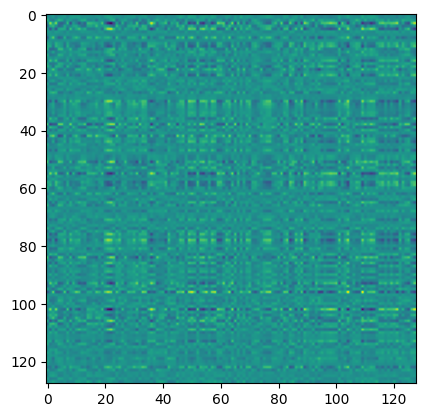

In [152]:
plt.imshow(model.B.weight.detach().cpu())

In [106]:
tt_layer = nn.Linear(2, 3)

In [108]:
tt_layer.weight

Parameter containing:
tensor([[ 0.5082,  0.3971],
        [ 0.5551,  0.1570],
        [ 0.4284, -0.3817]], requires_grad=True)

In [157]:
torch.svd(model.B.weight.detach())

torch.return_types.svd(
U=tensor([[-0.1237, -0.1925, -0.1679,  ..., -0.0024, -0.0079, -0.1396],
        [-0.1407, -0.1311, -0.1616,  ..., -0.0208,  0.1064, -0.0979],
        [ 0.1431,  0.0443,  0.1210,  ...,  0.0886,  0.0327, -0.0029],
        ...,
        [-0.0021, -0.0942,  0.0018,  ...,  0.0493, -0.0635,  0.1631],
        [-0.0120,  0.1182,  0.0052,  ..., -0.2189, -0.0033, -0.0617],
        [ 0.0481, -0.0134,  0.0287,  ..., -0.0642, -0.0336, -0.1245]],
       device='cuda:0'),
S=tensor([1.1846e+01, 9.7545e+00, 7.0845e+00, 3.1164e+00, 2.2533e+00, 2.1232e+00,
        1.6901e+00, 1.5698e+00, 1.3545e+00, 1.0379e+00, 9.5692e-01, 8.4064e-01,
        8.1813e-01, 7.5186e-01, 6.9887e-01, 6.4518e-01, 6.1042e-01, 5.5656e-01,
        5.3510e-01, 4.9338e-01, 4.6926e-01, 4.3150e-01, 4.1853e-01, 3.9370e-01,
        3.8257e-01, 3.5294e-01, 3.1897e-01, 3.1055e-01, 2.8639e-01, 2.6632e-01,
        2.5336e-01, 2.3900e-01, 2.3410e-01, 2.2365e-01, 2.1525e-01, 2.0664e-01,
        1.8841e-01, 1.7747e-01, 1

In [153]:
torch.svd(model.B.weight.detach())

torch.return_types.svd(
U=tensor([[ 4.2514e-02, -4.7158e-02,  2.2462e-04,  ...,  2.8887e-02,
         -8.8644e-02,  9.5902e-02],
        [ 5.2001e-02, -1.9911e-03,  1.6713e-02,  ..., -7.0159e-02,
          3.4867e-02,  5.8774e-02],
        [-2.8227e-02,  1.3928e-01,  3.2930e-02,  ...,  7.3368e-02,
          3.4970e-02,  1.1322e-01],
        ...,
        [-1.8006e-02, -4.8962e-02,  5.4508e-02,  ...,  2.3288e-01,
         -9.4987e-02,  8.4195e-02],
        [ 3.5192e-02,  6.0189e-02, -2.8392e-02,  ..., -1.8189e-01,
         -2.8962e-02,  2.6440e-02],
        [ 8.9151e-03, -1.0895e-02,  1.5154e-01,  ...,  6.7951e-03,
         -4.9047e-03, -1.4454e-02]], device='cuda:0'),
S=tensor([4.0978e+01, 2.6526e+01, 1.7523e+01, 3.6260e+00, 2.6081e+00, 2.2346e+00,
        1.4840e+00, 1.0984e+00, 1.0211e+00, 9.0502e-01, 8.5670e-01, 7.3854e-01,
        7.2794e-01, 6.1239e-01, 5.6039e-01, 5.2722e-01, 4.8615e-01, 4.6069e-01,
        4.1608e-01, 3.7225e-01, 3.5202e-01, 3.3735e-01, 3.0874e-01, 2.7767e-01,
  